In [1]:
import os

from ml.eval import eval_model

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

from ml.pipeline import FeitDataPipeline, ModelPipeline

from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules

from tensorflow.keras.callbacks import ReduceLROnPlateau

from cfg import *

from livelossplot import PlotLossesKerasTF

name = 'MySimpleCNN_Inception_module-v2-reduced-inception-residual-small'

/home/jelinek/recetox/histoseg/notebooks/Residual


In [2]:
def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1',
                        kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)

    return X


def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = keras.layers.Add()([X, X_shortcut])  # SKIP Connection
    X = keras.layers.Activation('relu')(X)

    return X


class MySimpleCnn_Feit(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size = 256

    @staticmethod
    def get_inception_module_dim_reduction(prev_layer, filters_1, filters_2):
        c11 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1, 1), padding='same')(prev_layer)
        c12 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1, 1), padding='same')(prev_layer)
        c13 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1, 1), padding='same')(prev_layer)
        p1 = keras.layers.MaxPooling2D(padding='same', strides=(1, 1), pool_size=(3, 3))(prev_layer)

        c21 = keras.layers.Conv2D(filters=filters_2, kernel_size=(3, 3), padding='same')(c12)
        c22 = keras.layers.Conv2D(filters=filters_2, kernel_size=(5, 5), padding='same')(c13)
        c23 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1, 1), padding='same')(p1)

        output_layer = keras.layers.concatenate([c11, c21, c22, c23], axis=-1)

        return output_layer

    @staticmethod
    def get_compiled_model(input_shape=(256, 256, 3)):
        X_input = keras.layers.Input(input_shape)

        X = keras.layers.ZeroPadding2D((3, 3))(X_input)

        X = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
        X = keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
        X = keras.layers.Activation('relu')(X)
        X = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

        X = convolutional_block(X, f=3, filters=[8, 8, 32], stage=2, block='a', s=1)
        X = identity_block(X, 3, [8, 8, 32], stage=2, block='b')
        X = identity_block(X, 3, [8, 8, 32], stage=2, block='c')

        X = convolutional_block(X, f=3, filters=[16, 16, 64], stage=3, block='a', s=2)
        X = identity_block(X, 3, [16, 16, 64], stage=3, block='b')
        X = identity_block(X, 3, [16, 16, 64], stage=3, block='c')
        X = identity_block(X, 3, [16, 16, 64], stage=3, block='d')

        X = convolutional_block(X, f=3, filters=[32, 32, 128], stage=4, block='a', s=2)
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='b')
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='c')
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='d')
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='e')
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='f')

        X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=5, block='a', s=2)
        X = identity_block(X, 3, [64, 64, 256], stage=5, block='b')
        X = identity_block(X, 3, [64, 64, 256], stage=5, block='c')

        X = keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

        X = keras.layers.Flatten()(X)
        X = keras.layers.Dense(units=12, activation='softmax')(X)

        model = keras.Model(inputs=X_input, outputs=X, name='ResNet50')

        model.summary()

        return model

    def _train_model(self, data_train, data_valid):

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, PlotLossesKerasTF()])

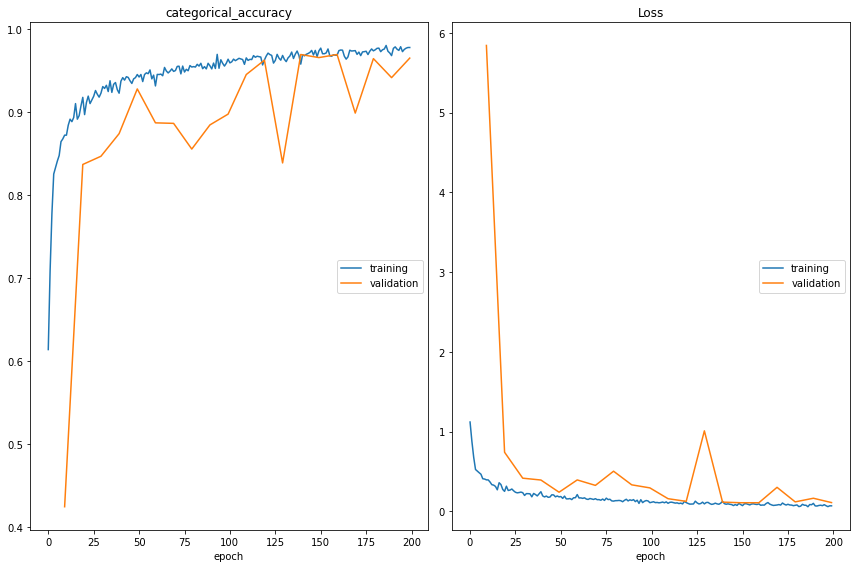

categorical_accuracy
	training         	 (min:    0.614, max:    0.980, cur:    0.978)
	validation       	 (min:    0.425, max:    0.969, cur:    0.965)
Loss
	training         	 (min:    0.058, max:    1.120, cur:    0.069)
	validation       	 (min:    0.108, max:    5.842, cur:    0.110)
102/102 [==============================] - 6s 58ms/step - loss: 0.1100 - categorical_accuracy: 0.9647
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.6668ms
Confusion Matrix
[[328   2   1   0   0   0   0   1   0   0   2   1]
 [  2  53   4   1   0   0   1   3   0   0   0   0]
 [  1   2 140   0   0   0   1   1   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0   0]
 [  0   0   1   1 542   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   2   2   0   0   0  72   1   0   0   0   0]
 [  0   0   0   0   0   0   1  85   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0]
 [ 13

In [3]:
pipeline = MySimpleCnn_Feit(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                            valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

keras.utils.plot_model(pipeline.model, 'model-figs/' + name + '.png')
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [4]:
pipeline.save_pipeline()

/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [3]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)
pipeline.params.number_of_classes = 12
pipeline.params.class_to_color_mapping = [
        'Purple',  # adenocarcinoma
        'Red',  # blood_and_vessels
        'silver',  # connective_tissue
        'White',  # empty
        'thistle',  # fat
        'magenta',  # inflammation_purulent
        'steelblue',  # muscle_cross_section
        'dodgerblue',  # muscle_longitudinal_section
        'darkred',  # necrosis
        'gold',  # nerve
        'seagreen',  # normal_mucosa
        'White'  # unknown
    ]
pipeline.params.class_names=sorted(list(selected_classes_feit.union( {'unknown'} )))

2022-05-15 21:39:28.107528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 21:39:28.141854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 21:39:28.142083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 21:39:28.142654: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 1 out of 120

2022-05-13 10:51:47.954074: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-05-13 10:51:49.262216: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Processing region 120 out of 120
Post-processing image...
Processing grid point 663499 out of 663499
Processing image took 2095.478144645691 seconds
Saving file...
File saved to segmentations/MySimpleCNN_Inception_module-v2-reduced-inception-residual-small/ns-adenoca-colon-15071-2019-20x-he-4.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1599360 out of 1599360
Processing image took 4893.54734992981 seconds
Saving file...
File saved to segmentations/MySimpleCNN_Inception_module-v2-reduced-inception-residual-small/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1544036 out of 1544036
Processing image took 4864.849551439285 seconds
Saving file...
File saved to segmentations/MySimpleCNN_Inception_module-v2-reduced-inception-residual-small/ns-adenoca-colon-3043-2019-20x-he-a

In [4]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         128, pipeline.params.class_names,
                                         save_segmentations=False, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1, include_unknown=False)

Processing region 1 out of 120

2022-05-15 21:39:32.631063: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-05-15 21:39:33.186409: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Processing region 120 out of 120
Post-processing image...
Processing grid point 41664 out of 41664
Processing image took 157.05803680419922 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 99960 out of 99960
Processing image took 368.3235659599304 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 96577 out of 96577
Processing image took 336.9384365081787 seconds
Processing region 567 out of 567
Post-processing image...
Processing grid point 220296 out of 220296
Processing image took 728.7881715297699 seconds
Aggregated evaluation: 
[[31001   353   476   191    12     0     4    69     0     0   936     0]
 [  127  3020   599    43   724     3    98    48     0     0   144     0]
 [  159   524  1386    64    91    12    87   430     0     0   515     0]
 [    6    14     0    46     1     0     0     0     0     0   733     0]
 [  117   633   458  2120 12474     1   112    16     0     0     0     0]
 [   30   